In [6]:
#from helper_funcs import bayes_step
import fastdyn_fic_dmf as dmf
from mango import Tuner, scheduler
from scipy.io import loadmat
import numpy as np
from joblib import Parallel, delayed
N_JOBS = 4


@scheduler.serial
def bayes_step_withG(G, DECAY, LR):
    OBJ_RATE = 3.44
    sampling_freq = 10000
    nb_steps = 100000
    C = loadmat('../SC_and_5ht2a_receptors.mat')['sc90']
    C = 0.2*C/np.max(C)
    triu_idx = np.triu_indices(C.shape[1],1)
    brunout = 5
    params = dmf.default_params(C=C)
    params['N'] = C.shape[0]
    #print(f"Running - G:{G} / DECAY:{DECAY} / OBJ_RATE:{OBJ_RATE} / LR:{LR} \n")
    with_decay = DECAY>0
    params['lrj'] = LR
    params['G'] = G
    params['taoj'] = DECAY if with_decay else 10 # If 0 it means no plasticity at all. We put some value so it does not crash
    params['obj_rate'] = OBJ_RATE
    #params['taoj'] = 210000
    params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
    rates, rates_inh, _, fic_t = dmf.run(params, nb_steps,
                                            return_rate=True, return_bold=False, return_fic=True, 
                                            with_decay=with_decay, with_plasticity=True)        
    rates = rates[:, np.ceil(brunout * 1000).astype(int):]
  
    homeostatic_fittness =  np.abs(OBJ_RATE - np.mean(rates))
    return homeostatic_fittness

@scheduler.parallel(n_jobs=N_JOBS)
def bayes_step_parallelized(DECAY, LR):
    OBJ_RATE = 3.44
    sampling_freq = 10000
    nb_steps = 100000
    C = loadmat('../SC_and_5ht2a_receptors.mat')['sc90']
    C = 0.2 * C / np.max(C)
    triu_idx = np.triu_indices(C.shape[1], 1)
    brunout = 5
    params = dmf.default_params(C=C)
    params['N'] = C.shape[0]
    
    G_average_list = list(np.arange(0.5, 6.5, 0.5))
    
    def compute_fitness_for_G(G):
        with_decay = DECAY > 0
        params['lrj'] = LR
        params['G'] = G
        params['taoj'] = DECAY if with_decay else 10
        params['obj_rate'] = OBJ_RATE
        params['J'] = 0.75 * params['G'] * params['C'].sum(axis=0).squeeze() + 1
        params['seed'] = 42
        rates, rates_inh, _, fic_t = dmf.run(params, nb_steps,
                                             return_rate=True, return_bold=False, return_fic=True,
                                             with_decay=with_decay, with_plasticity=True)
        rates = rates[:, np.ceil(brunout * 1000).astype(int):]

        return np.abs(OBJ_RATE - np.mean(rates))

    homeostatic_fittness_list = Parallel(n_jobs=4)(delayed(compute_fitness_for_G)(G) for G in G_average_list)
    mean_fit = np.mean(homeostatic_fittness_list)
    std_fit = np.std(homeostatic_fittness_list)
    homeostatic_fittness =  mean_fit + 0.5*mean_fit*std_fit
    print(f"\nmean = {mean_fit} std = {std_fit} hom = {homeostatic_fittness}\n")
    
    return homeostatic_fittness

@scheduler.serial
def bayes_step(DECAY, LR):
    OBJ_RATE = 3.44
    sampling_freq = 10000
    nb_steps = 100000
    C = loadmat('../SC_and_5ht2a_receptors.mat')['sc90']
    C = 0.2*C/np.max(C)
    triu_idx = np.triu_indices(C.shape[1],1)
    brunout = 5
    params = dmf.default_params(C=C)
    params['N'] = C.shape[0]
    #print(f"Running - G:{G} / DECAY:{DECAY} / OBJ_RATE:{OBJ_RATE} / LR:{LR} \n")
    G_average_list = list(np.arange(0.5,6.5,0.5))
    homeostatic_fittness_list = np.zeros(len(G_average_list))
    for idx,G in enumerate(G_average_list):
        with_decay = DECAY>0
        params['lrj'] = LR
        params['G'] = G
        params['taoj'] = DECAY if with_decay else 10 # If0 it means no plasticity at all. We put some value so it does not crash
        params['obj_rate'] = OBJ_RATE
        #params['taoj'] = 210000
        params['J'] = 0.75*params['G']*params['C'].sum(axis=0).squeeze() + 1
        rates, rates_inh, _, fic_t = dmf.run(params, nb_steps,
                                                return_rate=True, return_bold=False, return_fic=True, 
                                                with_decay=with_decay, with_plasticity=True)        
        rates = rates[:, np.ceil(brunout * 1000).astype(int):]
    
        homeostatic_fittness_list[idx] = np.abs(OBJ_RATE - np.mean(rates))
    homeostatic_fittness = np.mean(homeostatic_fittness_list)
    return homeostatic_fittness

In [ ]:
import random
lr_range = np.concatenate([np.arange(0.1, 1.1, 0.1), np.array(range(2, 401, 2))])
pbounds_withG = {'G': np.arange(1,6.5,0.5), 'DECAY': range(0,100001,200), 'LR':lr_range}
pbounds = {'DECAY': range(0, 100001, 200), 'LR': lr_range}
conf_dict = dict(num_iteration=4, initial_random=4)
tuner = Tuner(pbounds, bayes_step_parallelized, conf_dict)

# Create an empty list to store results
all_results = []

# Perform multiple optimization runs with different random seeds
for iteration in range(30):
    random_seed = iteration
    #random.seed(random_seed)
    
    # Minimize with the Tuner using the new random seed
    results = tuner.minimize()
    
    # Append the results of this iteration to the list
    all_results.append(results)
    
    # Print results for the current iteration
    print(f"Iteration {iteration + 1}:")
    print('Best parameters:', results['best_params'])
    print('Best accuracy:', results['best_objective'])

# Print all results
for i, result in enumerate(all_results, start=1):
    print(f"\nResults for Iteration {i}:")
    print('Best parameters:', result['best_params'])
    print('Best accuracy:', result['best_objective'])


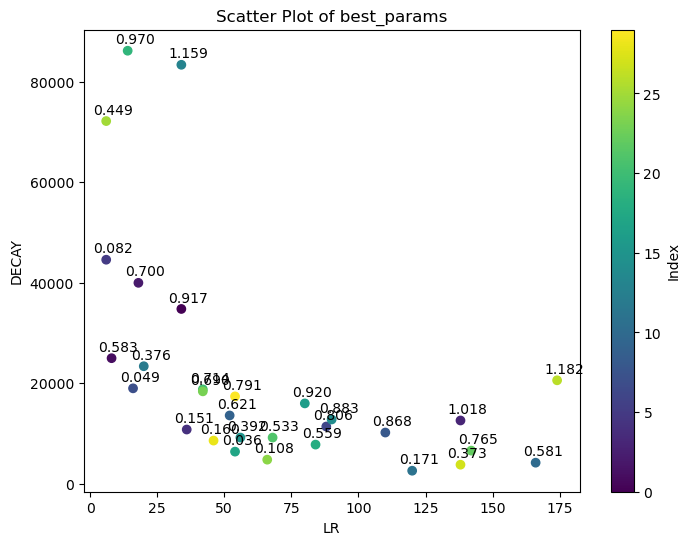

In [8]:
import matplotlib.pyplot as plt

# Extracting LR, DECAY, and best_objective values from all_results
LR_values = [result['best_params']['LR'] for result in all_results]
DECAY_values = [result['best_params']['DECAY'] for result in all_results]
best_objective_values = [result['best_objective'] for result in all_results]

# Generating a list of colors for each value in all_results
colors = range(len(all_results))

# Plotting the scatter plot
plt.figure(figsize=(8, 6))  # Set the figure size as needed
scatter = plt.scatter(LR_values, DECAY_values, c=colors, cmap='viridis')
plt.xlabel('LR')
plt.ylabel('DECAY')
plt.title('Scatter Plot of best_params')
plt.colorbar(scatter, label='Index')

# Adding annotations for each point
for i, txt in enumerate(best_objective_values):
    plt.annotate(f'{txt:.3f}', (LR_values[i], DECAY_values[i]), textcoords="offset points", xytext=(5,5), ha='center')

plt.show()


In [9]:
import pickle as pkl

file_name = "Homeostatic_fitness_30iter.pkl"

# Pickle the variable and save it to a file
with open(file_name, 'wb') as file:
    pkl.dump(all_results, file)

In [67]:
# Serial decorator
tuner = Tuner(pbounds_withG, bayes_step_withG, conf_dict)
results = tuner.minimize()
print('best parameters:', results['best_params'])
print('best accuracy:', results['best_objective'])

Best score: 0.5679424230969086: 100%|██████████| 20/20 [02:08<00:00,  6.40s/it]

best parameters: {'DECAY': 15600, 'G': 4.0, 'LR': 42.0}
best accuracy: 0.5679424230969086


In [57]:
# 4 jobs
tuner = Tuner(pbounds, bayes_step, conf_dict)
results = tuner.minimize()
print('best parameters:', results['best_params'])
print('best accuracy:', results['best_objective'])

Best score: 0.1987530043420267: 100%|██████████| 40/40 [05:56<00:00,  8.90s/it]

best parameters: {'DECAY': 1400, 'G': 3.5, 'LR': 312.0}
best accuracy: 0.1987530043420267


In [53]:
# 2 jobs
tuner = Tuner(pbounds, bayes_step, conf_dict)
results = tuner.minimize()
print('best parameters:', results['best_params'])
print('best accuracy:', results['best_objective'])

Best score: 0.012179817469832432: 100%|██████████| 40/40 [04:47<00:00,  7.20s/it]

best parameters: {'DECAY': 3400, 'G': 5.0, 'LR': 108.0}
best accuracy: 0.012179817469832432


In [55]:
# 1 job
tuner = Tuner(pbounds, bayes_step, conf_dict)
results = tuner.minimize()
print('best parameters:', results['best_params'])
print('best accuracy:', results['best_objective'])

Best score: 0.07216902358055544: 100%|██████████| 40/40 [04:16<00:00,  6.41s/it]

best parameters: {'DECAY': 22000, 'G': 3.0, 'LR': 16.0}
best accuracy: 0.07216902358055544
